In [ ]:
#default_exp ch01_problem02

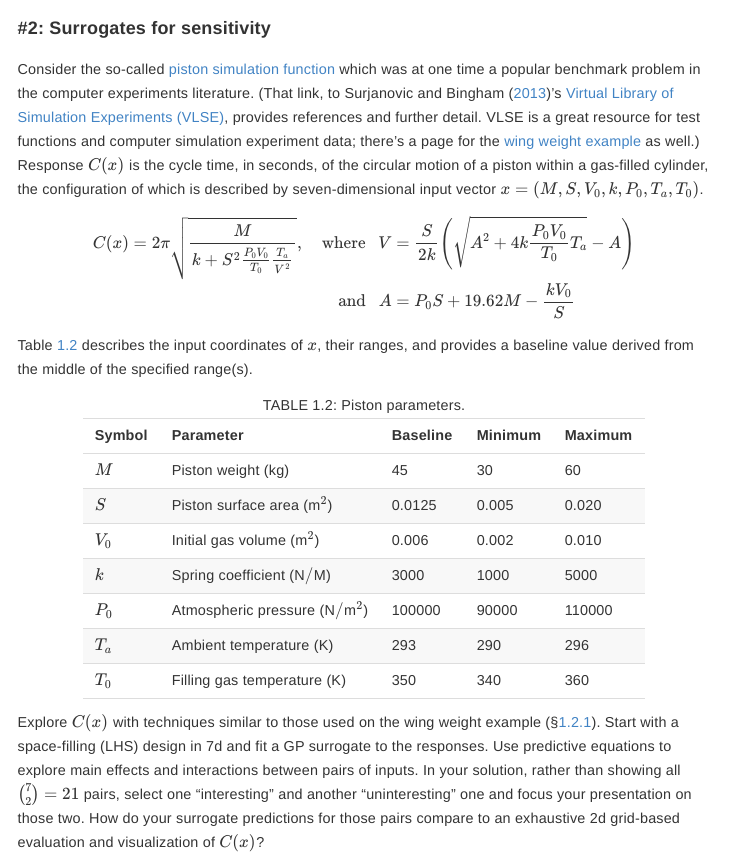!

In [86]:
%config Completer.use_jedi = False

In [132]:
import numpy as np
import pandas as pd
import pyDOE
import GPy
import plotnine as pn
from typing import List, Dict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import forestci

from surrogates import ch01_problem01

In [84]:
#export
def piston(M, S, V0, k, P0, Ta, T0):
    A = P0*S + 19.62*M - k*V0 / S
    V = (S / (2*k)) * (np.sqrt(A**2 + 4*k * (P0*V0 / T0) * Ta) - A)    
    sq_denom = k + S**2 * (P0*V0 / T0) * (Ta / V**2)
    return 2 * np.pi * np.sqrt(M / sq_denom)


def scale_to_range(v: pd.Series, target_min: float, target_max: float) -> pd.Series:
    vmin, vmax = v.min(), v.max()    
    return ((v - vmin) / (vmax - vmin)) * (target_max - target_min) + target_min


def scale_columns(df, stats_dict) -> None:    
    for var in df.columns:
        df[var] = df[var] + stats_dict[var]['baseline']
        df[var] = scale_to_range(
            df[var], 
            target_min=stats_dict[var]['minimum'],
            target_max=stats_dict[var]['maximum'])
        
def plot_heatmap_facets(long_grid_df):
    return (
        pn.ggplot(long_grid_df,
                  pn.aes(x='val1', y='val2', fill='pred')) +
        pn.geom_tile(pn.aes(width='width', height='height'), alpha=0.3) +
        pn.facet_wrap("name", scales="free") +
        pn.scale_fill_gradient(low='yellow', high='red') +
        pn.theme_bw() +
        pn.theme(figure_size=(14, 14), subplots_adjust={'hspace': 0.25, 'wspace': 0.25}))


def longify_grid(grid_df, variables: List[str], normalized: bool):
    """
    Makes a wide matrix, one column per variable,
    into a long one. Also adds heatmap-tile width and height to each
    variable combination.
    """
    bins = 1 if normalized else 40
    dfs = []
    for i, vari in enumerate(variables):
        for j, varj in enumerate(variables):
            if j <= i:
                continue
            df = grid_df[[vari, varj, 'pred']].copy()
            df.columns = ['val1', 'val2', 'pred']
            df['width'] = (df['val1'].max() - df['val1'].min()) / bins
            df['height'] = (df['val2'].max() - df['val2'].min()) / bins
            df['vari'] = vari
            df['varj'] = varj
            df['name'] = f"{vari}*{varj}"
            dfs.append(df)    
    return pd.concat(dfs)

            
def make_fit_dataframe(mean_fit: List[float], var_fit: List[float], y_actual: List[float]):
    fit_df = (
        pd.DataFrame(mean_fit, columns=['pred'])
        .assign(variance=var_fit,
                std=lambda d: np.sqrt(d['variance']),
                y=y_actual, 
                resid=lambda d: d['y'] - d['pred']))
    ch01_problem01.attach_std(fit_df, var_fit)
    return fit_df

In [4]:
rows = [
    ('M',  45,     30,    60),
    ('S',  0.0125, 0.005, 0.020),
    ('V0', 0.006,  0.002, 0.010),
    ('k',  3000,   1000,  5000),
    ('P0', 100000, 90000, 110000),
    ('Ta', 293,    290,   296),
    ('T0', 350,    340,   360)
]
ranges_df = pd.DataFrame(rows, columns=['var', 'baseline', 'minimum', 'maximum'])
variables = list(ranges_df['var'])

In [5]:
stats_dict = {}
for i, row in ranges_df.iterrows():
    stats = {}
    for name in ('baseline', 'minimum', 'maximum'):
        stats[name] = row[name]
    stats_dict[row['var']] = stats

In [6]:
baselines = dict([
    (var, baseline) for var, baseline in zip(ranges_df['var'], ranges_df['baseline'])])

In [7]:
baseline = piston(**baselines)

In [8]:
grid_matrix = pyDOE.lhs(len(variables), samples=1000)
grid_df = pd.DataFrame(grid_matrix, columns=variables)

SCALE_UP = True
if SCALE_UP:
    scale_columns(grid_df, stats_dict)

In [9]:
grid_df

,M,S,V0,k,P0,Ta,T0
0,34.099992,0.005521,0.008091,2994.976450,108011.508374,292.102877,343.748212
1,53.418735,0.005900,0.003413,2835.192837,92425.448946,293.766180,358.719284
2,49.582386,0.018427,0.009731,2021.090304,96593.133297,292.489081,359.396633
3,37.204823,0.012904,0.008975,1270.097996,100649.390725,291.780352,352.549648
4,35.486176,0.006339,0.006862,4595.784042,104516.059777,293.327088,343.438117
...,...,...,...,...,...,...,...
995,38.896045,0.012692,0.006961,1123.344594,92720.278560,294.460526,352.278149
996,48.977386,0.006438,0.006586,4281.913961,92464.159731,294.289315,353.297149
997,51.287210,0.013783,0.009365,4258.676640,101871.179111,291.912523,348.512648
998,36.013369,0.006249,0.005278,2444.273832,97609.841809,295.640328,354.215359


In [10]:
y_actual = grid_df.apply(lambda row: piston(**row), axis=1)
y_actual = y_actual.values.reshape((len(y_actual), 1))

In [169]:

#exports
class Modeler:
    def __init__(self, grid: pd.DataFrame, y_actual: List[float]):
        self.grid = grid
        self.matrix = grid.values
        self.y = y_actual
        self.variables = list(grid.columns)
        
    def get_predictions(self, matrix=None):
        if matrix is None:
            matrix = self.matrix
        return self.model.predict(matrix)
        
    def self_predict(self):
        mean_fit = self.get_predictions()
        resid_fit = mean_fit - self.y.ravel()
        var_fit = resid.var()
        self.fit_df = make_fit_dataframe(mean_fit, var_fit, y_actual)
        
    def fit_and_self_predict(self, kwargs={}):
        self.fit(kwargs)
        self.self_predict()
        
    def __repr__(self):
        try:
            kwargs_str = f" ({self.model_kwargs})"
        except AttributeError:
            kwargs_str = ""
        return f"{self.name}{kwargs_str}"
    
    def longify_grid(self, stats_dict, nsamples=10000*2, scale_up: bool = False):
        larger_grid_df = pd.DataFrame(pyDOE.lhs(len(self.grid.columns), samples=nsamples),
                                      columns=self.grid.columns)
        if scale_up:
            scale_columns(larger_grid_df, stats_dict)
        larger_grid_df['pred'] = self.get_predictions(larger_grid_df.values)
        return longify_grid(larger_grid_df, variables=self.grid.columns, 
                            normalized = not scale_up)
        

class LinearModeler(Modeler):
    name = "Linear regression"
    def fit(self, kwargs={}):
        self.model = LinearRegression(**kwargs).fit(self.grid, self.y.ravel())


class RFModeler(Modeler):
    name = "Random forest"
    def fit(self, kwargs={}):
        """
        :param kwargs: arguments to sklearn's RandomForestRegressor
        """
        self.model = RandomForestRegressor(**kwargs).fit(self.grid, self.y.ravel())


class GPModeler(Modeler):
    name = "Gaussian process"
        
    def fit(self, kwargs={}):
        self.model_kwargs = kwargs
        kernel = GPy.kern.RBF(input_dim=len(self.grid.columns), **kwargs)
        self.model = GPy.models.GPRegression(self.grid, self.y, kernel)
        
    def get_predictions(self):
        mean_fit, variance_of_fit = self.model.predict(self.grid.values)
        return [x[0] for x in mean_fit]
        
        
class PistonModeler(Modeler):
    name = "Actual function"
    
    def fit(self, kwargs={}):
        """
        :param kwargs: Ignored; only here for consistent API.
        """
        self.model = piston        

    def get_predictions(self, matrix=None):
        if matrix is None:
            matrix = self.matrix
        return [self.model(*matrix[i, :]) for i in range(matrix.shape[0])]


In [170]:
gp = GPModeler(grid_df, y_actual)
gp.fit_and_self_predict({'lengthscale': 10})

rf = RFModeler(grid_df, y_actual)
rf.fit_and_self_predict({'n_estimators': 1000, 'max_depth': 4})

lm = LinearModeler(grid_df, y_actual)
lm.fit_and_self_predict()

## The actual function.
pm = PistonModeler(grid_df, y_actual)
pm.fit_and_self_predict()

--------------------------------------------------------------------------------
Gaussian process ({'lengthscale': 10})


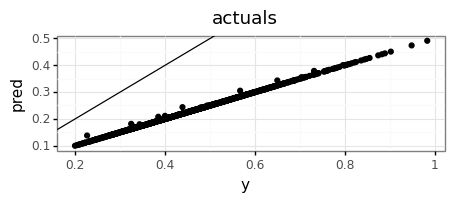

<ggplot: (8417182033146)>

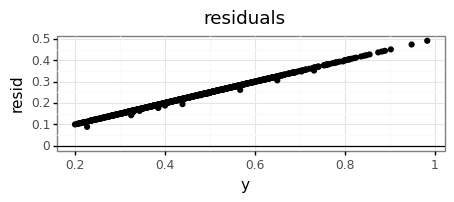

<ggplot: (8417181909209)>

--------------------------------------------------------------------------------
Random forest


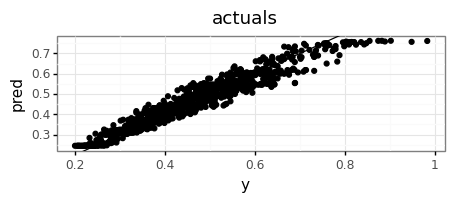

<ggplot: (8417179536818)>

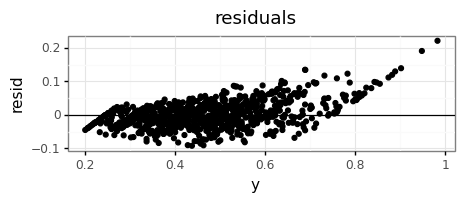

<ggplot: (8417182458802)>

--------------------------------------------------------------------------------
Linear regression


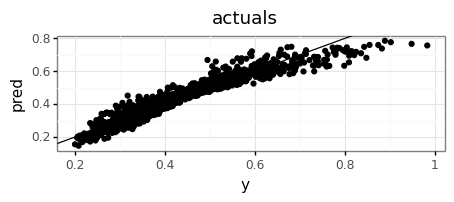

<ggplot: (8417181754865)>

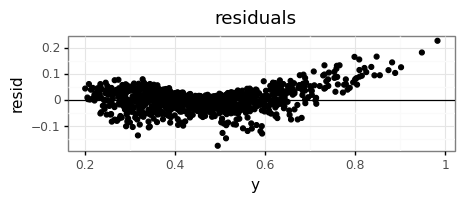

<ggplot: (8417186510758)>

--------------------------------------------------------------------------------
Actual function


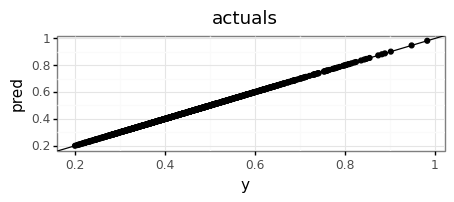

<ggplot: (8417189426014)>

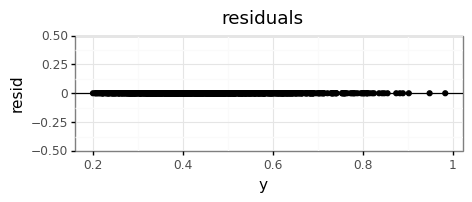

<ggplot: (8417182458393)>

In [163]:
for modeler in (gp, rf, lm, pm):
    print('-'*80)
    print(modeler)
    ch01_problem01.plot_predictions(modeler.fit_df, (5, 1.5))

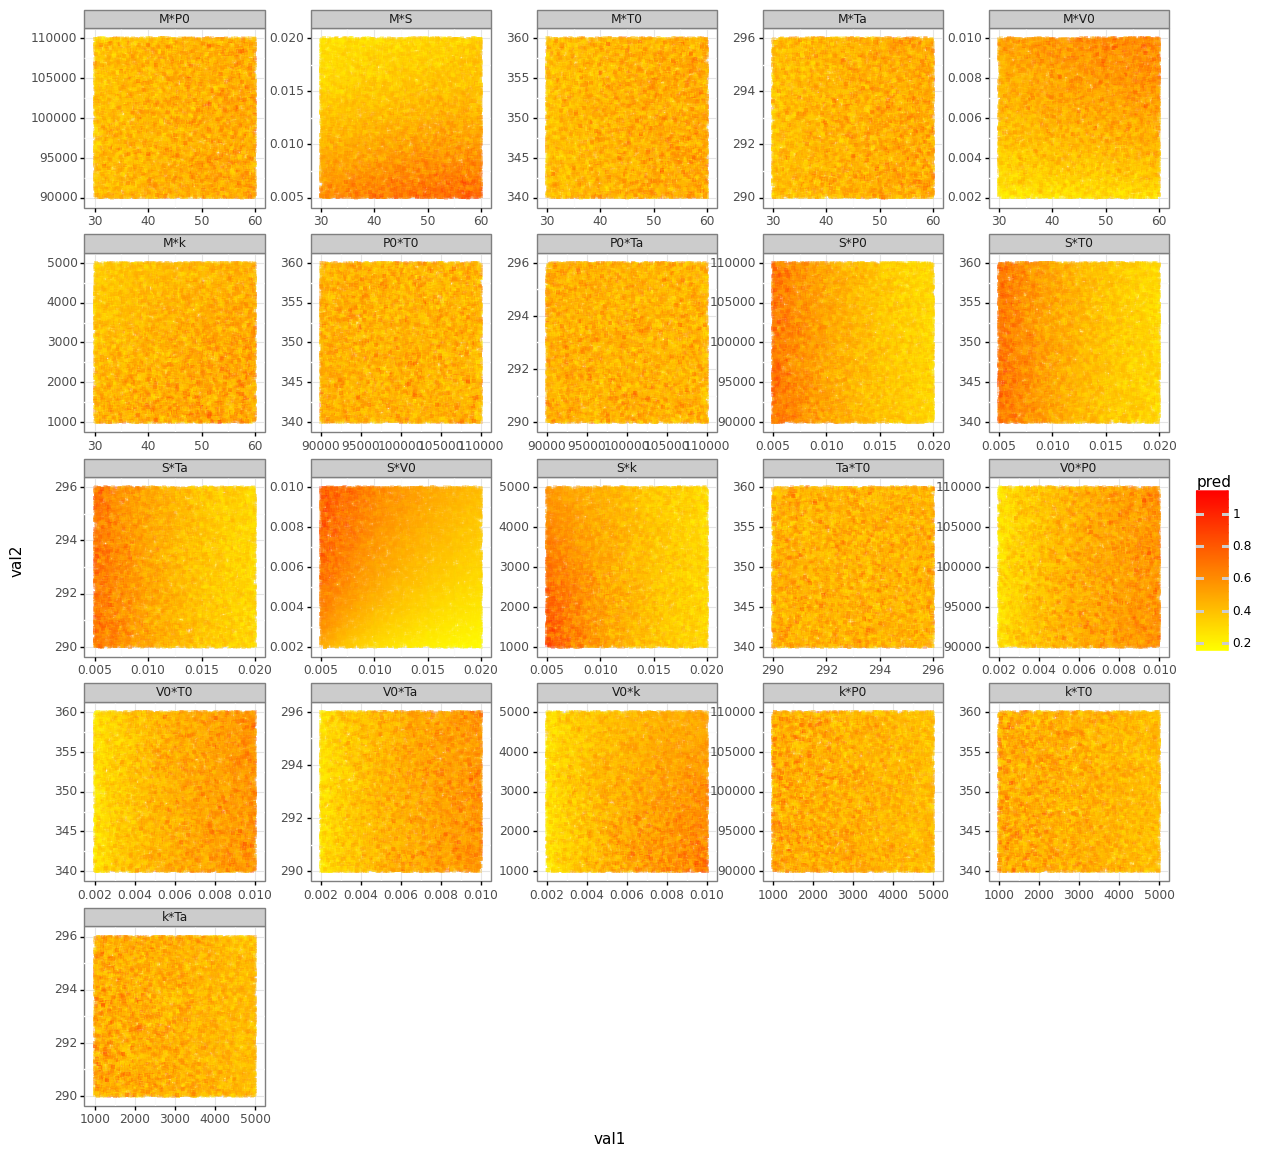

<ggplot: (8417214644459)>

In [171]:
plot_heatmap_facets(pm.longify_grid(stats_dict, scale_up=SCALE_UP))

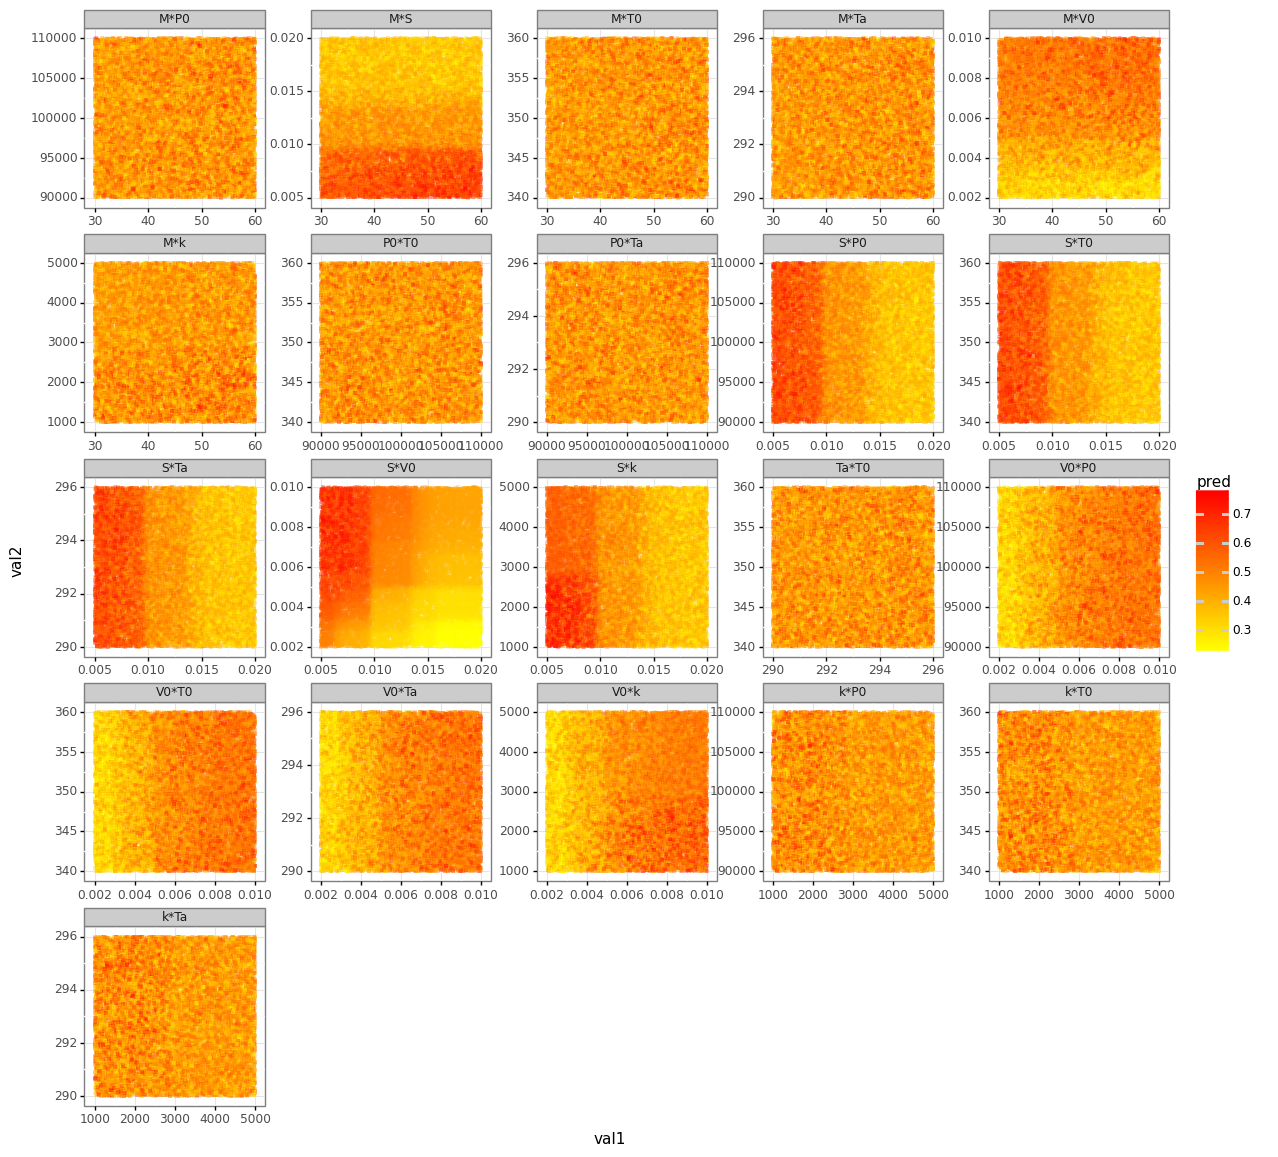

<ggplot: (8417188080463)>

In [172]:
plot_heatmap_facets(rf.longify_grid(stats_dict, scale_up=SCALE_UP))

In [173]:
from nbdev.export import *
notebook2script()

Converted ch01_problem01.ipynb.
Converted ch01_problem02.ipynb.
Converted index.ipynb.
